<a href="https://colab.research.google.com/github/nikm7777/D-code/blob/main/Multi_Image_Detection_and_Labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pycocotools.coco import COCO
import torchvision.transforms as tvt
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import skimage
import numpy as np
import imageio
from torch.utils.data import DataLoader
from PIL import Image
import pickle
import random
import torchvision.ops as ops
from sklearn.metrics import accuracy_score
import torchvision.transforms.functional as TF
import time
import torchvision
import torch.optim as optim
from matplotlib.patches import Rectangle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# filtering and loading required training images
input_json =  '/content/drive/MyDrive/ECE64600/annotations_trainval2014/annotations/instances_train2014.json'
class_list = ['cat','pizza','bus']
###########################
# Mapping from COCO label to Class indices
coco_labels_inverse = {}
coco = COCO ( input_json )
catIds = coco . getCatIds ( catNms = class_list )
categories = coco . loadCats ( catIds )

categories . sort ( key= lambda x: x['id'])
print ( categories )
# [{’ supercategory ’: ’vehicle ’, ’id ’: 6, ’name ’: ’bus ’}, {’supercategory ’: ’animal ’, ’id ’:, ’name ’: ’cat ’}, {’supercategory ’: ’food ’, ’id ’:, ’name ’: ’pizza ’}]
for idx , in_class in enumerate ( class_list ):
  for c in categories :
    if c['name'] == in_class :
      coco_labels_inverse [c['id']] = idx
print ( coco_labels_inverse )
 # {6: 0, 17: 1, 59: 2}
 # ############################
 # Retrieve Image list

img_list=[]
imgIds=[]
for c in class_list:
    catId = coco . getCatIds ( catNms = c )
    label=coco_labels_inverse[catId[0]]
    imgIds.extend(coco.getImgIds(catIds=catId))
    j=0
set_img=set(imgIds)
imgIds=list(set_img)
 # ############################
 # Display one random image with annotation
for i,image in  enumerate(imgIds):
      #catg=[]
     # bbox=[]
      #ann_list=[]
      img = coco . loadImgs ( image)[0]
      annIds = coco . getAnnIds ( imgIds = img['id'],iscrowd = False )
      anns = coco . loadAnns ( annIds )
      temp=0
      #if len(anns)<=8:
      for ann in anns:
          area=ann['area']
          if area>4096 and ann['category_id'] in catIds:
           #catg.append(ann['category_id'])
           #bbox.append(ann['bbox'])
           #ann_list.append(ann)
           temp+=1
      if temp>=1:
          img_list.append(image)

loading annotations into memory...
Done (t=27.36s)
creating index...
index created!
[{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'animal', 'id': 17, 'name': 'cat'}, {'supercategory': 'food', 'id': 59, 'name': 'pizza'}]
{17: 0, 59: 1, 6: 2}


In [ ]:
# Validation Images
input_json =  '/content/drive/MyDrive/ECE64600/annotations_trainval2014/annotations/instances_val2014.json'
class_list = ['cat','pizza','bus']
###########################
# Mapping from COCO label to Class indices
coco_labels_inverse = {}
coco = COCO ( input_json )
catIds = coco . getCatIds ( catNms = class_list )
categories = coco . loadCats ( catIds )

categories . sort ( key= lambda x: x['id'])
print ( categories )
# [{’ supercategory ’: ’vehicle ’, ’id ’: 6, ’name ’: ’bus ’}, {’supercategory ’: ’animal ’, ’id ’:, ’name ’: ’cat ’}, {’supercategory ’: ’food ’, ’id ’:, ’name ’: ’pizza ’}]
for idx , in_class in enumerate ( class_list ):
  for c in categories :
    if c['name'] == in_class :
      coco_labels_inverse [c['id']] = idx
print ( coco_labels_inverse )
 # {6: 0, 17: 1, 59: 2}
 # ############################
 # Retrieve Image list

img_list=[]
imgIds=[]
for c in class_list:
    catId = coco . getCatIds ( catNms = c )
    label=coco_labels_inverse[catId[0]]
    imgIds.extend(coco.getImgIds(catIds=catId))
    j=0
set_img=set(imgIds)
imgIds=list(set_img)
 # ############################
 # Display one random image with annotation
for i,image in  enumerate(imgIds):
      #catg=[]
     # bbox=[]
      #ann_list=[]
      img = coco . loadImgs ( image)[0]
      annIds = coco . getAnnIds ( imgIds = img['id'],iscrowd = False )
      anns = coco . loadAnns ( annIds )
      temp=0
      #if len(anns)<=8:
      for ann in anns:
          area=ann['area']
          if area>4096 and ann['category_id'] in catIds:
           #catg.append(ann['category_id'])
           #bbox.append(ann['bbox'])
           #ann_list.append(ann)
           temp+=1
      if temp>=1:
          img_list.append(image)

loading annotations into memory...
Done (t=5.21s)
creating index...
index created!
[{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'animal', 'id': 17, 'name': 'cat'}, {'supercategory': 'food', 'id': 59, 'name': 'pizza'}]
{17: 0, 59: 1, 6: 2}


In [ ]:
#saving and reshaping training images
metadata=[]
for i,image in  enumerate(img_list):
      catg=[]
      bbox=[]
      ann_list=[]
      img = coco . loadImgs ( image)[0]
      annIds = coco . getAnnIds ( imgIds = img['id'],iscrowd = False )
      anns = coco . loadAnns ( annIds )
      temp=0
      for ann in anns:
          if ann['category_id'] in catIds and ann['area']>4096:
            catg.append(ann['category_id'])
            bbox.append(ann['bbox'])
            #ann_list.append(ann['id'])
      dimage={}
      dimage['label']=[]
      dimage['bbox']=[]
      I = imageio . imread ( img['coco_url'])
      shape=I.shape
      I = Image.fromarray(I).resize((256,256))
      if  I.mode!= 'RGB':
          I = I.convert('RGB')
      path=f'/content/drive/MyDrive/ECE64600/Train/{i}.jpg'
      I.save(path)
      dimage['path']=path
      for j, box in enumerate(bbox):
            x_tleft=box[0]
            y_tleft=box[1]
            x_bright=x_tleft+box[2]
            y_bright=y_tleft+box[3]
            xn_tleft=x_tleft*(1/(shape[1]-1))
            yn_tleft=y_tleft*(1/(shape[0]-1))
            xn_bright=x_bright*(1/(shape[1]-1))
            yn_bright=y_bright*(1/(shape[0]-1))
            dimage['bbox'].append((xn_tleft,yn_tleft,xn_bright,yn_bright))
            dimage['label'].append(coco_labels_inverse[catg[j]])
      metadata.append(dimage)
#idx = np.random.randint(0 , len( imgIds ))


<ipython-input-40-50e36fed0c54>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio . imread ( img['coco_url'])


KeyboardInterrupt: ignored

In [ ]:
metadata_test=[]
for i,image in  enumerate(img_list):
      catg=[]
      bbox=[]
      ann_list=[]
      img = coco . loadImgs ( image)[0]
      annIds = coco . getAnnIds ( imgIds = img['id'],iscrowd = False )
      anns = coco . loadAnns ( annIds )
      temp=0
      for ann in anns:
          if ann['category_id'] in catIds and ann['area']>4096:
            catg.append(ann['category_id'])
            bbox.append(ann['bbox'])
            #ann_list.append(ann['id'])
      dimage={}
      dimage['label']=[]
      dimage['bbox']=[]
      I = imageio . imread ( img['coco_url'])
      shape=I.shape
      I = Image.fromarray(I).resize((256,256))
      if  I.mode!= 'RGB':
          I = I.convert('RGB')
      path=f'/content/drive/MyDrive/ECE64600/Test/{i}.jpg'
      I.save(path)
      dimage['path']=path
      for j, box in enumerate(bbox):
            x_tleft=box[0]
            y_tleft=box[1]
            x_bright=x_tleft+box[2]
            y_bright=y_tleft+box[3]
            xn_tleft=x_tleft*(1/(shape[1]-1))
            yn_tleft=y_tleft*(1/(shape[0]-1))
            xn_bright=x_bright*(1/(shape[1]-1))
            yn_bright=y_bright*(1/(shape[0]-1))
            dimage['bbox'].append((xn_tleft,yn_tleft,xn_bright,yn_bright))
            dimage['label'].append(coco_labels_inverse[catg[j]])
      metadata_test.append(dimage)
#idx = np.random.randint(0 , len( imgIds ))


<ipython-input-7-a4dd8dcfbef4>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio . imread ( img['coco_url'])


In [ ]:
#with open('/content/drive/MyDrive/ECE64600/Train_data.pkl', 'wb') as f:
    #pickle.dump(metadata, f)
#with open('/content/drive/MyDrive/ECE64600/Test_data.pkl', 'wb') as f:
  #pickle.dump(metadata_test,f)

In [ ]:
with open('/content/drive/MyDrive/ECE64600/Test_data.pkl','rb') as f:
  dict_test=pickle.load(f)
len(dict_test)

3491

In [ ]:
# Reload the dictionary from the file
with open('/content/drive/MyDrive/ECE64600/Train_data.pkl', 'rb') as f:
    reloaded_dict = pickle.load(f)

len(reloaded_dict)

6883

In [ ]:
metadata=reloaded_dict[0:6880]
metadata1=dict_test[0:500]

In [ ]:
path0=[]
path1=[]
path2=[]
bbox0=[]
label0=[]
bbox1=[]
label1=[]
bbox2=[]
label2=[]
temp=0
random.shuffle(reloaded_dict)
for i,j in enumerate(reloaded_dict):
  if temp==3:
    break
  if all(x == 0 for x in j['label']) and len(j['label'])>1:
    path0.append(j['path'])
    bbox0.append(j['bbox'])
    label0.append(j['label'])
    temp+=1

temp=0
for i,j in enumerate(reloaded_dict):
  if temp==3:
    break
  if all(x == 1 for x in j['label']) and len(j['label'])>1:
    path1.append(j['path'])
    bbox1.append(j['bbox'])
    label1.append(j['label'])
    temp+=1

temp=0
for i,j in enumerate(reloaded_dict):
  if temp==3:
    break
  if all(x == 2 for x in j['label']) and len(j['label'])>1:
    path2.append(j['path'])
    bbox2.append(j['bbox'])
    label2.append(j['label'])
    temp+=1

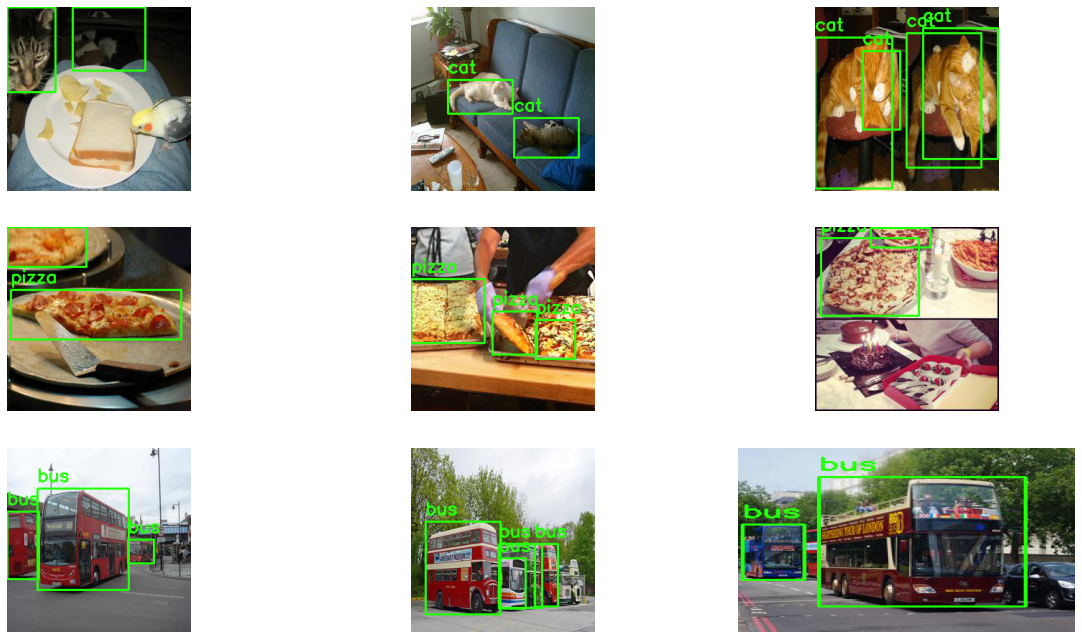

In [ ]:
#plotting randomly sampled images from dataset alomng with annotations
label_dict={0:'cat',1:'pizza',2:'bus'}
fig , ax = plt . subplots (3 , 3 )
fig.set_size_inches(20.5, 11.5, forward=True)
i,j,k=0,0,0
for i,path in enumerate(path0):
    I=imageio.imread(path)
    #im = np.asarray(im)
    im = np . uint8 (I)
    for j,bbox in enumerate(bbox0[i]):
      x , y , w , h = bbox
      im = cv2 . putText (im , label_dict[label0[i][j]], (int( x*255 ) , int(y *255)-10 ) , cv2 .FONT_HERSHEY_SIMPLEX ,0.8 , ( 36 , 255 , 12 ) , 2 )
      im = cv2 . rectangle ( im , (int( x*255 ) , int( y*255) ) , (int( w*255) ,int ( h*255 ) ) , ( 36 , 255 , 12 ) , 2 )
    ax[0][i] . imshow ( im )
    ax[0][i] . set_axis_off ()

for i,path in enumerate(path1):
    I=imageio.imread(path)
    #im = np.asarray(im)
    im = np . uint8 (I)
    for j,bbox in enumerate(bbox1[i]):
      x , y , w , h = bbox
      im = cv2 . putText (im , label_dict[label1[i][j]], (int( x*255 ) , int(y *255)-10 ) , cv2 .FONT_HERSHEY_SIMPLEX ,0.8 , ( 36 , 255 , 12 ) , 2 )
      im = cv2 . rectangle ( im , (int( x*255 ) , int( y*255) ) , (int( w*255) ,int ( h*255 ) ) , ( 36 , 255 , 12 ) , 2 )
    ax[1][i] . imshow ( im )
    ax[1][i] . set_axis_off ()

for i,path in enumerate(path2):
    I=imageio.imread(path)
    #im = np.asarray(im)
    im = np . uint8 (I)
    for j,bbox in enumerate(bbox2[i]):
      x , y , w , h = bbox
      im = cv2 . putText (im , label_dict[label2[i][j]], (int( x*255 ) , int(y *255)-10 ) , cv2 .FONT_HERSHEY_SIMPLEX ,0.8 , ( 36 , 255 , 12 ) , 2 )
      im = cv2 . rectangle ( im , (int( x*255 ) , int( y*255) ) , (int( w*255) ,int ( h*255 ) ) , ( 36 , 255 , 12 ) , 2 )
    ax[2][i] . imshow ( im )
    ax[2][i] . set_axis_off ()


plt . axis ('tight')
plt . show ()


In [ ]:

#custom dataloader
class My_Dataset(torch.utils.data.Dataset):
  def __init__(self,metadata):
    super().__init__()
    self.metadata=metadata

  def __len__(self):

      return len(self.metadata)

  def __getitem__(self,index):
      di=self.metadata[index]
      self.image=Image.open(di['path'])
      self.label = torch.zeros(8, dtype=torch.uint8) + 13
      self.bbox = torch.zeros(8,4, dtype=torch.float)
      for i in range(len(di['label'])):
        if i<8:
          self.label[i]=di['label'][i]
          self.bbox[i,:]=torch.Tensor(di['bbox'][i])
      if len(di['label'])<=8:
        self.num_object=len(di['label'])
      else:
        self.num_object=len(di['label'])
      #self.bb_tensor = torch.tensor(self.bbox, dtype=torch.float)
      #self.label_tensor=torch.tensor(self.label, dtype=torch.uint8)

      self.transform=tvt.Compose([tvt.ToTensor(),tvt.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) #applying image transforms
      self.image=self.transform(self.image)
      return self.image,self.label,self.bbox,self.num_object



In [ ]:
Train_data= My_Dataset(metadata)
Train_dataloader=DataLoader(Train_data,num_workers=2,batch_size=10,shuffle=True)

In [ ]:
Test_data= My_Dataset(metadata1)
Test_dataloader=DataLoader(Test_data,num_workers=2,batch_size=1)

In [ ]:
class SkipBlock(nn.Module):                #defining skipblock
            """
            This is a building-block class that I have used in several networks
            """
            def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
                super(SkipBlock, self).__init__()
                self.downsample = downsample
                self.skip_connections = skip_connections
                self.in_ch = in_ch
                self.out_ch = out_ch
                self.convo1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
                self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
                norm_layer1 = nn.BatchNorm2d
                norm_layer2 = nn.BatchNorm2d
                self.bn1 = norm_layer1(out_ch)
                self.bn2 = norm_layer2(out_ch)
                if downsample:
                    self.downsampler = nn.Conv2d(in_ch, out_ch, 1, stride=2)
            def forward(self, x):
                identity = x
                out = self.convo1(x)
                out = self.bn1(out)
                out = torch.nn.functional.relu(out)
                if self.in_ch == self.out_ch:
                    out = self.convo2(out)
                    out = self.bn2(out)
                    out = torch.nn.functional.relu(out)
                if self.downsample:
                    out = self.downsampler(out)
                    identity = self.downsampler(identity)
                if self.skip_connections:
                    if self.in_ch == self.out_ch:
                        out += identity
                    else:
                        out[:,:self.in_ch,:,:] += identity
                        out[:,self.in_ch:,:,:] += identity
                return out

In [ ]:
class NetForYolo(nn.Module):            # Deep neural net

            def __init__(self, skip_connections=True, depth=8):
                super(NetForYolo, self).__init__()
                self.depth = depth // 2
                self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
                self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
                self.pool = nn.MaxPool2d(2, 2)
                self.bn1  = nn.BatchNorm2d(64)
                self.bn2  = nn.BatchNorm2d(128)
                self.bn3  = nn.BatchNorm2d(256)
                self.skip64_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip64_arr.append(SkipBlock(64, 64,skip_connections=skip_connections))
                self.skip64ds =SkipBlock(64,64,downsample=True,skip_connections=skip_connections)
                self.skip64to128 =SkipBlock(64, 128, skip_connections=skip_connections )
                self.skip128_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip128_arr.append(SkipBlock(128,128,skip_connections=skip_connections))
                self.skip128ds = SkipBlock(128,128,downsample=True, skip_connections=skip_connections)
                self.skip128to256 = SkipBlock(128, 256,skip_connections=skip_connections )
                self.skip256_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip256_arr.append(SkipBlock(256,256,skip_connections=skip_connections))
                self.skip256ds = SkipBlock(256,256,downsample=True, skip_connections=skip_connections)
                self.fc_seqn = nn.Sequential(
                    nn.Linear(8192, 7031),
                    nn.ReLU(inplace=True),
                    nn.Linear(7031, 4096),
                    nn.ReLU(inplace=True),
                    nn.Linear(4096, 2048),
                    nn.ReLU(inplace=True),
#                    nn.Linear(2048, 1440)
                    nn.Linear(2048, 1620),
                    nn.ReLU(inplace=True),
                    nn.Linear(1620, 405)
                )

            def forward(self, x):
                x = self.pool(torch.nn.functional.relu(self.conv1(x)))
                x = nn.MaxPool2d(2,2)(torch.nn.functional.relu(self.conv2(x)))
                for i,skip64 in enumerate(self.skip64_arr[:self.depth//4]):
                    x = skip64(x)
                x = self.skip64ds(x)
                for i,skip64 in enumerate(self.skip64_arr[self.depth//4:]):
                    x = skip64(x)
                x = self.bn1(x)
                x = self.skip64to128(x)
                for i,skip128 in enumerate(self.skip128_arr[:self.depth//4]):
                    x = skip128(x)
                x = self.bn2(x)
                x = self.skip128ds(x)
                x = x.view(-1, 8192 ).detach()
                x = self.fc_seqn(x)
                return x



In [ ]:
num_layers = len( list (nikhil . parameters () ) )
num_layers


162

In [ ]:
#code producing YOLO tensor for given batch size and training the network
def run_code_for_training_multi_instance_detection(net,train_dataloader,batch_size,learning_rate,yolo_interval,momentum,epochs,image_size, display_labels=False, display_images=False,yolo_debug=False):

            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            net = net.to(device)
            criterion1 = nn.BCELoss()                    # For the first element of the 8 element yolo vector
            criterion2 = nn.MSELoss()                    # For the regression elements (indexed 2,3,4,5) of yolo vector
            criterion3 = nn.CrossEntropyLoss()           # For the last three elements of the 8 element yolo vector
            print("\n\nLearning Rate: ",learning_rate)
            optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
            print("\n\nStarting training loop...\n\n")
            start_time = time.perf_counter()
            Loss_tally = []
            Loss_tally1=[]
            Loss_tally2=[]
            Loss_tally3=[]
            elapsed_time = 0.0
            yolo_interval = yolo_interval
            num_yolo_cells = (image_size[0] // yolo_interval) * (image_size[1] // yolo_interval)
            num_anchor_boxes =  5    # (height/width)   1/5  1/3  1/1  3/1  5/1
            max_obj_num  = 8
            ## The 8 in the following is the size of the yolo_vector for each anchor-box in a given cell.  The 8 elements
            ## are: [obj_present, bx, by, bh, bw, c1, c2, c3] where bx and by are the delta diffs between the centers
            ## of the yolo cell and the center of the object bounding box in terms of a unit for the cell width and cell
            ## height.  bh and bw are the height and the width of object bounding box in terms of the cell height and width.
            for epoch in range(epochs):
                print("")
                running_loss = 0.0
                running_loss1 = 0.0
                running_loss2 = 0.0
                running_loss3 = 0.0
                for iter, data in enumerate(train_dataloader):

                    yolo_tensor = torch.zeros( batch_size, num_yolo_cells, num_anchor_boxes, 8 )
                    im_tensor, bbox_label_tensor,bbox_tensor, num_objects_in_image = data
                    im_tensor   = im_tensor.to(device)
                    bbox_tensor = bbox_tensor.to(device)
                    bbox_label_tensor = bbox_label_tensor.to(device)
                    yolo_tensor = yolo_tensor.to(device)
                    cell_height = yolo_interval
                    cell_width = yolo_interval
                    num_cells_image_width = image_size[0] // yolo_interval
                    num_cells_image_height = image_size[1] // yolo_interval
                    height_center_bb = torch.zeros(batch_size,im_tensor.shape[0], 1).float().to(device)
                    width_center_bb = torch.zeros(batch_size,im_tensor.shape[0], 1).float().to(device)
                    obj_bb_height = torch.zeros(batch_size,im_tensor.shape[0], 1).float().to(device)
                    obj_bb_width =  torch.zeros(batch_size,im_tensor.shape[0], 1).float().to(device)

                    ## idx is for object index
                    for idx in range(max_obj_num):
                        ## In the mask, 1 means good image instance in batch, 0 means bad image instance in batch
#                        batch_mask = torch.ones( self.rpg.batch_size, dtype=torch.int8).to(self.rpg.device)

                        ## in what follows, the first index (set to 0) is for the batch axis

                        height_center_bb =  (bbox_tensor[:,idx,1]*255 + bbox_tensor[:,idx,3]*255) // 2
                                             ## (25)
                        width_center_bb =  (bbox_tensor[:,idx,0]*255 + bbox_tensor[:,idx,2]*255) // 2
                        obj_bb_height = bbox_tensor[:,idx,3]*255 -  bbox_tensor[:,idx,1]*255
                        obj_bb_width = bbox_tensor[:,idx,2]*255 - bbox_tensor[:,idx,0]*255
                        #if (obj_bb_height < 4.0) or (obj_bb_width < 4.0): continue

                        cell_row_indx =  (height_center_bb / yolo_interval).int()          ## for the i coordinate
                        cell_col_indx =  (width_center_bb / yolo_interval).int()
                                 ## for the j coordinates        ## (31)
                        cell_row_indx = torch.clamp(cell_row_indx, max=num_cells_image_height - 1)
                                             ## (32)
                        cell_col_indx = torch.clamp(cell_col_indx, max=num_cells_image_width - 1)

                        ## The bh and bw elements in the yolo vector for this object:  bh and bw are measured relative
                        ## to the size of the grid cell to which the object is assigned.  For example, bh is the
                        ## height of the bounding-box divided by the actual height of the grid cell.
                        bh  =  obj_bb_height.float() / yolo_interval
                        bw  =  obj_bb_width.float()  / yolo_interval

                        ## You have to be CAREFUL about object center calculation since bounding-box coordinates
                        ## are in (x,y) format --- with x-positive going to the right and y-positive going down.
                        obj_center_x =  (bbox_tensor[:,idx,2].float()*255 +  bbox_tensor[:,idx,0].float()*255) / 2.0

                        obj_center_y =  (bbox_tensor[:,idx,3].float()*255 +  bbox_tensor[:,idx,1].float()*255) / 2.0
                        ## Now you need to switch back from (x,y) format to (i,j) format:
                        yolocell_center_i =  cell_row_indx*yolo_interval + float(yolo_interval) / 2.0
                        yolocell_center_j =  cell_col_indx*yolo_interval + float(yolo_interval) / 2.0
                        del_x  =  (obj_center_x.float() - yolocell_center_j.float()) / yolo_interval

                        del_y  =  (obj_center_y.float() - yolocell_center_i.float()) / yolo_interval
                        class_label_of_object = bbox_label_tensor[:,idx]

                        index=[]
                        for i in range(batch_size):
                          if class_label_of_object[i] == 13: continue
                                                                         ## (43)
                          AR = obj_bb_height[i].float() / obj_bb_width[i].float()
                          if AR <= 0.2:               anch_box_index = 0
                          if 0.2 < AR <= 0.5:         anch_box_index = 1
                          if 0.5 < AR <= 1.5:         anch_box_index = 2
                          if 1.5 < AR <= 4.0:         anch_box_index = 3
                          if AR > 4.0:                anch_box_index = 4
                          yolo_vector = torch.FloatTensor([0,del_x[i].item(), del_y[i].item(), bh[i].item(), bw[i].item(), 0, 0, 0] )
                          yolo_vector[0] = 1

                          yolo_vector[5 + class_label_of_object[i].item()] = 1
                          yolo_cell_index =  cell_row_indx[i] * num_cells_image_width  +  cell_col_indx[i]

                                ## (53)
                          yolo_tensor[i,yolo_cell_index.item(), anch_box_index] = yolo_vector


                                         ## (54)
                        yolo_tensor_aug = torch.zeros(batch_size, num_yolo_cells,num_anchor_boxes,9).float().to(device)
                        yolo_tensor_aug[:,:,:,:-1] =  yolo_tensor

                    ## If no object is present, throw all the prob mass into the extra 9th ele of yolo_vector
                    for ibx in range(batch_size):
                     for icx in range(num_yolo_cells):
                        for iax in range(num_anchor_boxes):
                            if yolo_tensor_aug[ibx,icx,iax,0] == 0:
                                yolo_tensor_aug[ibx,icx,iax,-1] = 1


                    optimizer.zero_grad()
                    output = net(im_tensor)
                    predictions_aug = output.view(batch_size,num_yolo_cells,num_anchor_boxes,9)
                    loss = torch.tensor(0.0, requires_grad=True).float().to(device)
                    bcloss = torch.tensor(0.0, requires_grad=True).float().to(device)
                    rloss = torch.tensor(0.0, requires_grad=True).float().to(device)
                    clloss = torch.tensor(0.0, requires_grad=True).float().to(device)
                    for icx in range(num_yolo_cells):
                        for iax in range(num_anchor_boxes):
                          if torch.any(yolo_tensor_aug[:,icx,iax,0]):
                            pred_yolo_vector = predictions_aug[:,icx,iax]

                            target_yolo_vector = yolo_tensor_aug[:,icx,iax]

                            ##  Estimating presence/absence of object and the Binary Cross Entropy section:
                            object_presence = nn.Sigmoid()(pred_yolo_vector[:,0])
                            target_for_prediction = target_yolo_vector[:,0]
                            bceloss = criterion1(object_presence, target_for_prediction)
                            bcloss+=bceloss
                            loss += bceloss
                            ## MSE section for regression params:
                            pred_regression_vec = pred_yolo_vector[:,1:5]
                            #pred_regression_vec = torch.unsqueeze(pred_regression_vec, dim=0)
                            target_regression_vec = target_yolo_vector[:,1:5]
                            regression_loss = criterion2(pred_regression_vec, target_regression_vec)
                            rloss+=regression_loss
                            loss += regression_loss
                            ##  CrossEntropy section for object class label:
                            probs_vector = pred_yolo_vector[:,5:]
                            #probs_vector = torch.unsqueeze( probs_vector, dim=0 )
                            target = torch.argmax(target_yolo_vector[:,5:],dim=1)



                            class_labeling_loss = criterion3(probs_vector, target)
                            clloss+= class_labeling_loss
                            loss += class_labeling_loss


                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    running_loss1 += bcloss.item()
                    running_loss2 += rloss.item()
                    running_loss3 += clloss.item()
                    if iter%50==49:
                        current_time = time.perf_counter()
                        elapsed_time = current_time - start_time
                        avg_loss = running_loss / float(1000)
                        print("\n[epoch:%d/%d, iter=%4d  elapsed_time=%5d secs]      mean value for loss: %7.4f" %
                                                            (epoch+1,epochs, iter+1, elapsed_time, avg_loss))
                        Loss_tally.append(running_loss)
                        Loss_tally1.append(running_loss1)
                        Loss_tally2.append(running_loss2)
                        Loss_tally3.append(running_loss3)
                        running_loss = 0.0
                        running_loss1 = 0.0
                        running_loss2 = 0.0
                        running_loss3 = 0.0

            print("\nFinished Training\n")

            return net,Loss_tally,Loss_tally1,Loss_tally2,Loss_tally3

In [ ]:
 nikhil=NetForYolo()
 nikhil_net,Loss_tally,Loss_tally1,Loss_tally2,Loss_tally3=run_code_for_training_multi_instance_detection(nikhil,Train_dataloader,learning_rate=1e-4,batch_size=10,yolo_interval=40,momentum=0.9,epochs=10,image_size=[256,256], display_labels=False, display_images=False,yolo_debug=False)



Learning Rate:  0.0001


Starting training loop...




[epoch:1/10, iter=  50  elapsed_time=   10 secs]      mean value for loss:  1.3724

[epoch:1/10, iter= 100  elapsed_time=   21 secs]      mean value for loss:  1.3400

[epoch:1/10, iter= 150  elapsed_time=   31 secs]      mean value for loss:  1.2823

[epoch:1/10, iter= 200  elapsed_time=   42 secs]      mean value for loss:  1.1284

[epoch:1/10, iter= 250  elapsed_time=   52 secs]      mean value for loss:  0.8782

[epoch:1/10, iter= 300  elapsed_time=   63 secs]      mean value for loss:  0.8575

[epoch:1/10, iter= 350  elapsed_time=   73 secs]      mean value for loss:  0.8266

[epoch:1/10, iter= 400  elapsed_time=   83 secs]      mean value for loss:  0.7936

[epoch:1/10, iter= 450  elapsed_time=   94 secs]      mean value for loss:  0.7756

[epoch:1/10, iter= 500  elapsed_time=  105 secs]      mean value for loss:  0.8243

[epoch:1/10, iter= 550  elapsed_time=  114 secs]      mean value for loss:  0.8207

[epoch:1/10, iter= 

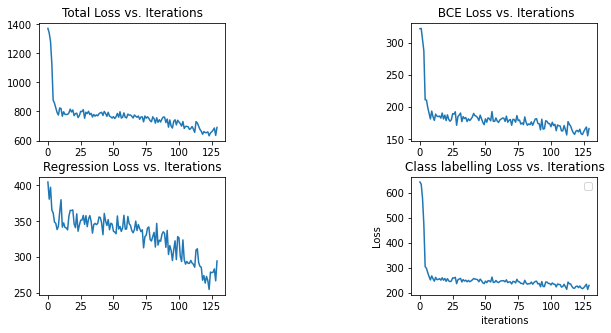

In [ ]:
#plotting the losses
fig, ax = plt.subplots(2, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.3, wspace=1)
ax[0,0].set_title("Total Loss vs. Iterations")
ax[0,0].plot(Loss_tally)
ax[0,1].set_title(" BCE Loss vs. Iterations")
ax[0,1].plot(Loss_tally1)
ax[1,0].set_title("Regression Loss vs. Iterations")
ax[1,0].plot(Loss_tally2)
ax[1,1].set_title("Class labelling Loss vs. Iterations")
ax[1,1].plot(Loss_tally3)

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def run_code_for_testing_multi_instance_detection( net,test_dataset,index, display_images=False,yolo_debug=True):     #code for testing and  extracting annotations from Predicted Yolo Tensor for test images
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            class_labels={0:'bus',1:'cat',2:'pizza'}
            yolo_debug = False
            #net.load_state_dict(torch.load(self.rpg.path_saved_yolo_model))
            net = net.to(device)
            yolo_interval = 40
            image_size=[256,256]
            num_yolo_cells = (256 // yolo_interval) * (256// yolo_interval)
            num_anchor_boxes =  5    # (height/width)   1/5  1/3  1/1  3/1  5/1
            ##  The next 5 assignment are for the calculations of the confusion matrix
            cell=[]
            anchor=[]
            ##  We also need to report the IoU values for the different types of objects

            #num_of_validation_images = len(test_dataloader)
            #print("\n\nNumber of images in the validation dataset: ", num_of_validation_images)


                    ##  In the following, the tensor bbox_label_tensor looks like: tensor([0,0,13,13,13], device='cuda:0',dtype=torch.uint8)
                    ##  where '0' is a genuine class label for 'Dr.Eval' and the number 13 as a label represents the case when there is no
                    ##  object.  You see, each image has a max of 5 objects in it. So the 5 positions in the tensor are for each of those objects.
                    ##  The bounding-boxes for each of those five objects are in the tensor bbox_tensor and segmentation masks in seg_mask_tensor.
            for i,data in enumerate(test_dataset):
              if index==i:
                test_image=data
            im_tensor, bbox_label_tensor ,bbox_tensor,num_objects_in_image = test_image

            im_tensor   = im_tensor.to(device)

            bbox_tensor = bbox_tensor.to(device)*255
            output = net(im_tensor)
            batch_size=1
            predictions = output.view(batch_size,num_yolo_cells,num_anchor_boxes,9).detach()
            num_cells_image_width = image_size[0] // yolo_interval                                        ## (18)
            num_cells_image_height = image_size[1] // yolo_interval                                       ## (19)
            height_center_bb = torch.zeros(im_tensor.shape[0], 1).float().to(device)                      ## (20)
            width_center_bb = torch.zeros(im_tensor.shape[0], 1).float().to(device)                       ## (21)
            obj_bb_height = torch.zeros(im_tensor.shape[0], 1).float().to(device)                         ## (22)
            obj_bb_width =  torch.zeros(im_tensor.shape[0], 1).float().to(device)                         ## (23)
            for idx in range(8):
              height_center_bb =  (bbox_tensor[0,idx,1] + bbox_tensor[0,idx,3]) // 2
                          ## (25)
              width_center_bb =  (bbox_tensor[0,idx,0] + bbox_tensor[0,idx,2]) // 2                              ## (26)
              obj_bb_height = bbox_tensor[0,idx,3] -  bbox_tensor[0,idx,1]                                       ## (27)
              obj_bb_width = bbox_tensor[0,idx,2] - bbox_tensor[0,idx,0]                                         ## (28)
                        #if (obj_bb_height < 4.0) or (obj_bb_width < 4.0): continue                                         ## (29)

              cell_row_indx =  (height_center_bb / yolo_interval).int()          ## for the i coordinate         ## (30)
              cell_col_indx =  (width_center_bb / yolo_interval).int()           ## for the j coordinates        ## (31)
              cell_row_indx = torch.clamp(cell_row_indx, max=num_cells_image_height - 1)                         ## (32)
              cell_col_indx = torch.clamp(cell_col_indx, max=num_cells_image_width - 1)

              class_label_of_object = bbox_label_tensor[0,idx].item()
              if class_label_of_object == 13: continue
              AR = obj_bb_height.float() / obj_bb_width.float()                                                  ## (44)
              if AR <= 0.2:               anch_box_index = 0                                                     ## (45)
              if 0.2 < AR <= 0.5:         anch_box_index = 1                                                     ## (46)
              if 0.5 < AR <= 1.5:         anch_box_index = 2                                                     ## (47)
              if 1.5 < AR <= 4.0:         anch_box_index = 3                                                     ## (48)
              if AR > 4.0:                anch_box_index = 4
              yolo_cell_index =  cell_row_indx.item() * num_cells_image_width  +  cell_col_indx.item()                                                                                ## (43)
              cell.append(yolo_cell_index)
              anchor.append(anch_box_index)


                        ## We will now identify the objects in the retained cells and also extract their bounding boxes:
            objects_detected = []
            predicted_bboxes  = []
            predicted_labels_for_bboxes = []
            predicted_label_index_vals = []
            for k, icx in enumerate(cell):
                            pred_vec = predictions[0,icx, anchor[k]]
                            class_labels_predi  = pred_vec[-4:]
                            class_labels_probs = torch.nn.Softmax(dim=0)(class_labels_predi)
                            class_labels_probs = class_labels_probs[:-1]
                            if torch.all(class_labels_probs < 0.00001):
                                predicted_class_label = None
                            else:
                                ## Get the predicted class label:
                                best_predicted_class_index = (class_labels_probs == class_labels_probs.max())
                                best_predicted_class_index = torch.nonzero(best_predicted_class_index, as_tuple=True)
                                predicted_label_index_vals.append(best_predicted_class_index[0].item())
                                predicted_class_label = class_labels[best_predicted_class_index[0].item()]
                                predicted_labels_for_bboxes.append(predicted_class_label)
                                ## Analyze the predicted regression elements:
                                pred_regression_vec = pred_vec[1:5].cpu()
                                del_x,del_y = pred_regression_vec[0], pred_regression_vec[1]
                                h,w = pred_regression_vec[2]+2, pred_regression_vec[3]+2
                                h *= yolo_interval
                                w *= yolo_interval
                                cell_row_index =  icx // 6
                                cell_col_index =  icx % 6
                                bb_center_x = cell_col_index * yolo_interval  +  yolo_interval/2  +  del_x * yolo_interval
                                bb_center_y = cell_row_index * yolo_interval  +  yolo_interval/2  +  del_y * yolo_interval
                                bb_top_left_x =  int(bb_center_x - w/2 )
                                bb_top_left_y =  int(bb_center_y - h/2 )
                                predicted_bboxes.append( [bb_top_left_x, bb_top_left_y, int(w), int(h)] )
                        ## make a deep copy of the predicted_bboxes for eventual visual display:

            for pred_bbox in predicted_bboxes:
                            w,h = pred_bbox[2], pred_bbox[3]
                            pred_bbox[2] = pred_bbox[0] + w
                            pred_bbox[3] = pred_bbox[1] + h

            return predicted_bboxes, predicted_labels_for_bboxes


<ipython-input-161-a33718cb2504>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I=imageio.imread(metadata1[j]['path'])


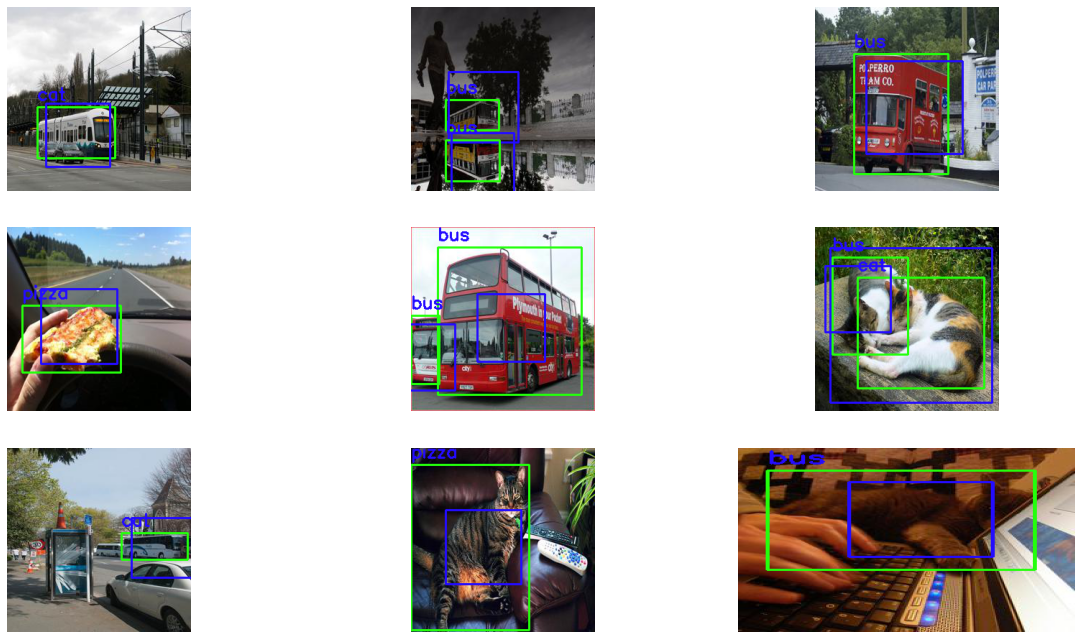

In [ ]:
#plotting test images with predicted  and ground truth annotations
#blue color = predicted
#green  color= ground truth
label_dict={0:'cat',1:'pizza',2:'bus'}
fig , ax = plt . subplots (3 , 3 )
fig.set_size_inches(20.5, 11.5, forward=True)
k=0
count=0
list_images1=[391,79,91,47,99,38,17,276,441]
list_images=[4,155,344,76,299,99,441,286,33]
for i,j in enumerate(list_images):
    count+=1
    predicted_bboxes, predicted_labels_for_bboxes=run_code_for_testing_multi_instance_detection(nikhil_net,Test_dataloader,j)
    I=imageio.imread(metadata1[j]['path'])
    #im = np.asarray(im)
    im = np . uint8 (I)
    for z,bbox in enumerate(predicted_bboxes):
      x , y , w , h = metadata1[j]['bbox'][z]
      x1,y1,x2,y2=bbox
      im = cv2 . putText (im , predicted_labels_for_bboxes[z], (int( x*255 ) , int(y *255)-10 ) , cv2 .FONT_HERSHEY_SIMPLEX ,0.8 , ( 36 , 12 , 255 ) , 2 )
      im = cv2 . rectangle ( im , (int( x*255 ) , int( y*255) ) , (int( w*255) ,int ( h*255 ) ) , ( 36 , 255 , 12 ) , 2 )
      im = cv2 . rectangle ( im , (int( x1 ) , int( y1) ) , (int(x2) ,int (y2) ) , ( 36 , 12 , 255 ) , 2 )
    ax[k][i%3] . imshow ( im )
    ax[k][i%3] . set_axis_off ()

    if count%3==0:
      k+=1



plt . axis ('tight')
plt . show ()
